## ETL + EDA project using Banco Central do Brasil time series of 4 currency pairs: USD/BRL, EUR/BRL, JPY/BRL and GBP/BRL. Developed as part of my Economics undergraduate final project.


## Requirements

In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

#import pymc3 as pm
#import pylab
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Extraction and Transformation

### BCB API Data Extraction

In [ ]:
def gerar_base_bcb(cod):   
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(cod)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    return df

In [ ]:
usd_bcb = gerar_base_bcb('10813')
eur_bcb = gerar_base_bcb('21620')
jpy_bcb = gerar_base_bcb('21622')
gbp_bcb = gerar_base_bcb('21624')

### DXY

In [ ]:
dxy_inv1 = pd.read_csv(r'Índice Dólar Dados Históricos.csv')
dxy_inv2 = pd.read_csv(r'Índice Dólar Dados Históricos (1).csv')

dxy_inv1 = dxy_inv1.iloc[::-1].reset_index().drop('index', axis=1) 
dxy_inv2 = dxy_inv2.iloc[::-1].reset_index().drop('index', axis=1)

dxy_inv = pd.concat([dxy_inv1, dxy_inv2], ignore_index=True) 
dxy_inv = dxy_inv.drop(['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], axis=1) 
dxy_inv = dxy_inv.rename(columns={'Data':'data', 'Último':'valor'})

dxy_inv['data'] = dxy_inv['data'].str.replace('.', '-') 
dxy_inv['valor'] = dxy_inv['valor'].str.replace(',', '.')

dxy_inv['data'] = pd.to_datetime(dxy_inv['data'], dayfirst=True) 
dxy_inv = dxy_inv.astype({'valor':'float64'})

dxy_inv.tail()

,data,valor
5769,2021-04-23,90.86
5770,2021-04-26,90.81
5771,2021-04-27,90.91
5772,2021-04-28,90.53
5773,2021-04-29,90.60


dxy_inv1 = pd.read_csv(r'Índice Dólar Dados Históricos.csv')
dxy_inv2 = pd.read_csv(r'Índice Dólar Dados Históricos (1).csv')

dxy_inv1 = dxy_inv1.iloc[::-1].reset_index().drop('index', axis=1)
dxy_inv2 = dxy_inv2.iloc[::-1].reset_index().drop('index', axis=1)

dxy_inv = pd.concat([dxy_inv1, dxy_inv2], ignore_index=True)
dxy_inv = dxy_inv.drop(['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], axis=1)
dxy_inv = dxy_inv.rename(columns={'Data':'data', 'Último':'valor'})

dxy_inv['data'] = dxy_inv['data'].str.replace('.', '-')
dxy_inv['valor'] = dxy_inv['valor'].str.replace(',', '.')

dxy_inv['data'] = pd.to_datetime(dxy_inv['data'], dayfirst=True)
dxy_inv = dxy_inv.astype({'valor':'float64'})

dxy_inv.tail()

### Returns


In [ ]:
def calcular_retornos(df):
    df['retorno'] = (df['valor'] / df['valor'].shift(1)) - 1
    # df['log_retorno'] = np.log(df['valor']) - np.log(df['valor'].shift(1))
    df = df.drop('valor', axis=1)
    return df

In [ ]:
usd_ret = calcular_retornos(usd_bcb).rename(columns={'retorno':'usd'})
eur_ret = calcular_retornos(eur_bcb).rename(columns={'retorno':'eur'})
jpy_ret = calcular_retornos(jpy_bcb).rename(columns={'retorno':'jpy'})
gbp_ret = calcular_retornos(gbp_bcb).rename(columns={'retorno':'gbp'})

In [ ]:
dxy_ret = calcular_retornos(dxy_inv).rename(columns={'retorno':'dxy'})
dxy_ret.tail()

,data,dxy
5769,2021-04-23,-0.005146
5770,2021-04-26,-0.000550
5771,2021-04-27,0.001101
5772,2021-04-28,-0.004180
5773,2021-04-29,0.000773


### Slicing (only data from 1999 and beyond)

In [ ]:
def recorte_serie(df):    
   
    ### SELECIONAR VALORES A PARTIR DE 1999 (REAL E EURO)    
    df = df.loc[df['data'] >= '01-01-1999'].reset_index().drop('index', axis=1)
    df = df.loc[df['data'] <= '31-12-2020'].reset_index().drop('index', axis=1)
    return df

In [ ]:
usd = recorte_serie(usd_ret)
eur = recorte_serie(eur_ret)
jpy = recorte_serie(jpy_ret)
gbp = recorte_serie(gbp_ret)

In [ ]:
def recorte_serie_dxy(df):    
   
    ### SELECIONAR VALORES A PARTIR DE 1999 (REAL E EURO)    
    df = df.loc[df['data'] >= '01-01-1999'].reset_index().drop('index', axis=1)
    #df = df.loc[df['data'] <= '31-01-2021'].reset_index().drop('index', axis=1)
    return df

dxy = recorte_serie_dxy(dxy_ret)

In [ ]:
dxy = dxy.set_index('data')
dxy

,dxy
data,
1999-01-01,0.000000
1999-01-04,-0.007752
1999-01-05,0.000321
1999-01-06,0.011341
1999-01-07,-0.008569
...,...
2021-04-23,-0.005146
2021-04-26,-0.000550
2021-04-27,0.001101


In [ ]:
dxy.to_excel('ret_dxy.xlsx')
dxy.to_csv('ret_dxy.csv')

In [ ]:
dxy.to_csv('ret_dxy.csv')

In [ ]:
dxy.describe().kurtosis()

dxy    8.0
dtype: float64

### Merge

In [ ]:
print(len(usd))
print(len(eur))
print(len(gbp))
print(len(jpy))
#print(len(dxy))

5525
5521
5521
5520


In [ ]:
df_eur = pd.merge(usd, eur, how='left', on='data')
df_gbp = pd.merge(df_eur, gbp, how='left', on='data')
df = pd.merge(df_gbp, jpy, how='left', on='data')

In [ ]:
#df_dxy = pd.merge(df, dxy, how='left', on='data')

In [ ]:
df

,data,usd,eur,gbp,jpy
0,1999-01-04,-0.000745,0.006905,0.001609,0.005133
1,1999-01-05,0.000580,-0.000148,-0.003098,0.005757
2,1999-01-06,0.000911,-0.012939,0.000671,-0.013295
3,1999-01-07,0.000414,0.008763,-0.002005,0.017404
4,1999-01-08,0.000248,-0.009993,-0.003383,0.001288
...,...,...,...,...,...
5520,2020-12-24,0.000986,0.001317,0.005948,0.000200
5521,2020-12-28,0.011567,0.013800,0.001365,0.010212
5522,2020-12-29,-0.008552,-0.006283,-0.005678,-0.006343
5523,2020-12-30,0.000481,0.005300,0.009236,0.003790


### Removing null values

In [ ]:
df_null = df[df.isna().any(axis=1)]
df_null

,data,usd,eur,gbp,jpy
3502,2012-12-12,0.002797,NaN,NaN,NaN
3850,2014-05-05,0.002926,NaN,NaN,NaN
4562,2017-03-01,-0.000549,-0.000825,-0.014059,NaN
5017,2018-12-26,0.010634,NaN,NaN,NaN
5510,2020-12-10,-0.005029,NaN,NaN,NaN


In [ ]:
# df = df.fillna(df.rolling(6,min_periods=1).mean())

df = df.dropna()
print(len(df))

5520


### Indexing

In [ ]:
usd = usd.set_index('data')
eur = eur.set_index('data')
gbp = gbp.set_index('data')
jpy = jpy.set_index('data')

df = df.set_index('data')

# EDA

### Descriptive Statistics

In [ ]:
desc_stats = df.describe()
desc_stats.loc['var'] = df.var().tolist()
desc_stats.loc['skew'] = df.skew().tolist()
desc_stats.loc['kurt'] = df.kurtosis().tolist()
desc_stats

,usd,eur,gbp,jpy
count,5520.000000,5520.000000,5520.000000,5520.000000
mean,0.000313,0.000330,0.000287,0.000354
std,0.010099,0.010701,0.010541,0.012161
min,-0.089368,-0.091125,-0.094090,-0.086477
25%,-0.004662,-0.005290,-0.005299,-0.005898
50%,0.000000,0.000009,0.000123,0.000000
75%,0.004796,0.005642,0.005585,0.006055
max,0.111103,0.103173,0.112916,0.112787
var,0.000102,0.000115,0.000111,0.000148
skew,0.585043,0.419638,0.357080,0.692594


In [ ]:
stats_temp = desc_stats.transpose().reset_index().rename(columns={'index':'moeda'})
stats_temp

,moeda,count,mean,std,min,25%,50%,75%,max,var,skew,kurt
0,usd,5520.0,0.000313,0.010099,-0.089368,-0.004662,0.000000,0.004796,0.111103,0.000102,0.585043,12.883463
1,eur,5520.0,0.000330,0.010701,-0.091125,-0.005290,0.000009,0.005642,0.103173,0.000115,0.419638,9.758910
2,gbp,5520.0,0.000287,0.010541,-0.094090,-0.005299,0.000123,0.005585,0.112916,0.000111,0.357080,11.010606
3,jpy,5520.0,0.000354,0.012161,-0.086477,-0.005898,0.000000,0.006055,0.112787,0.000148,0.692594,9.190858


In [ ]:
# stats.to_excel('estat_desc.xlsx')

### Time Series Plots

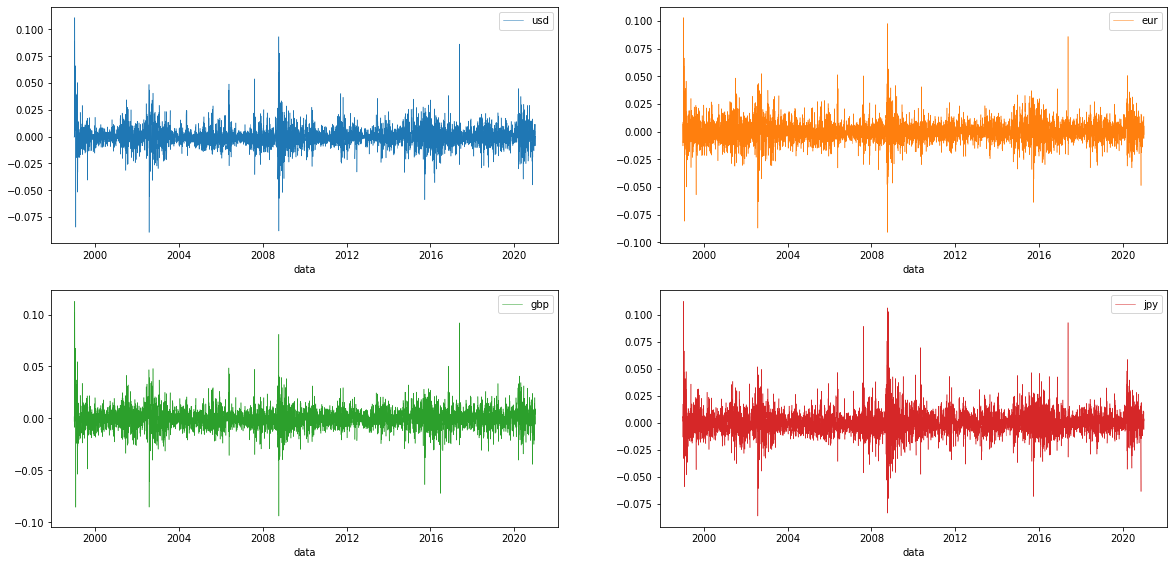

In [ ]:
df.plot(subplots=True, 
        linewidth=0.5, 
        layout=(4, 2), 
        figsize=(20, 20), 
        sharex=False,
        sharey=False
       )
plt.show()

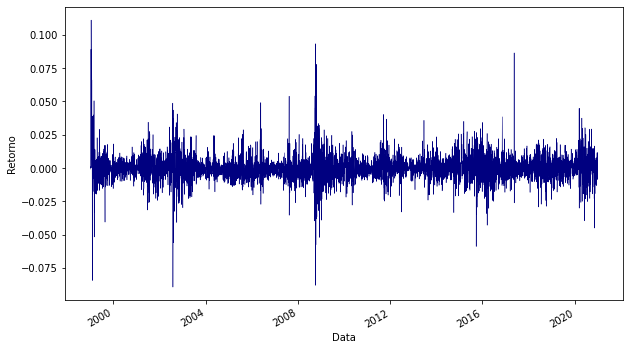

In [ ]:
# navy, darkgreen, maroon, olive
ax = df.usd.plot(linewidth=0.5, figsize=(10,6), color='navy')
ax.set_xlabel('Data')
ax.set_ylabel('Retorno')
plt.show()

### Histograms

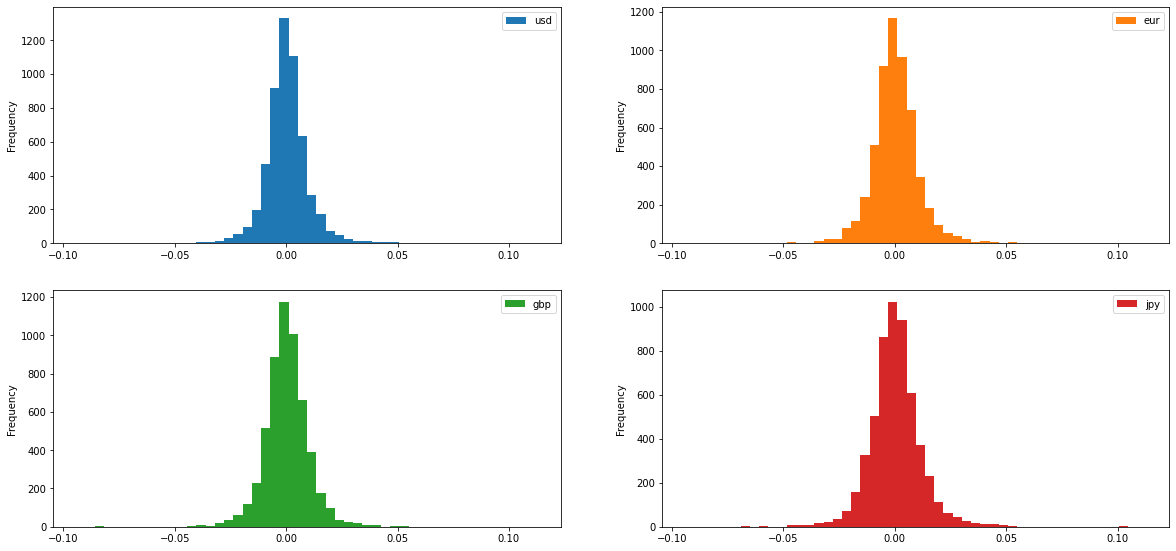

In [ ]:
# df.columns = pd.CategoricalIndex(['usd', 'eur', 'gbp', 'jpy'], ordered=True)
df.plot.hist(sort_columns=False, 
             subplots=True,
             layout=(4, 2), 
             figsize=(20, 20),
             sharex=False,
             sharey=False,
             bins=50)
plt.show()

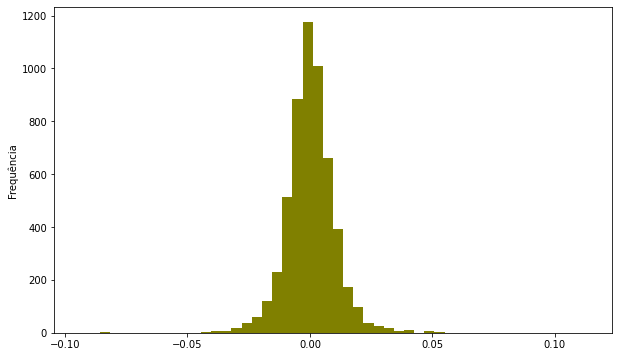

In [ ]:
ax = df.gbp.plot.hist(figsize=(10,6), bins=50, color='olive')
ax.set_ylabel('Frequência')
plt.show()

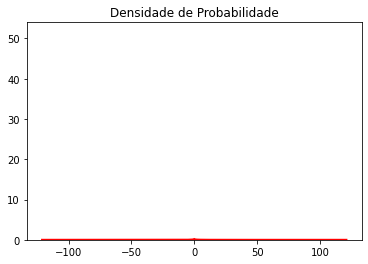

In [ ]:
fig, ax = plt.subplots(1,1)

x = np.linspace(stats.norm.ppf(0.0001, df.gbp.mean(), df.gbp.std()),
                stats.norm.ppf(0.9999, df.gbp.mean(), df.gbp.std()), 5520)

y = np.linspace(stats.gennorm.ppf(0.0001, 0.5),
                stats.gennorm.ppf(0.9999, 0.5), 5520)

#ax.plot(x, stats.norm.pdf(x, df.gbp.mean(), df.gbp.std()), 'r-', lw=2)
#ax.hist(df.gbp, density=True, histtype='stepfilled', bins=50)

ax.plot(y, stats.gennorm.pdf(y, 0.5), 'r-', lw=2)
ax.hist(df.gbp, density=True, histtype='stepfilled', bins=50)

#ax.plot(y, stats.t.pdf(y, 5519), 'r-', lw=2)
#ax.hist(df.gbp, density=True, stacked=True, weights=np.ones(len(df.gbp))/len(df.gbp), histtype='stepfilled', bins=50)

ax.set_title('Densidade de Probabilidade')
plt.show()

### Outliers

In [ ]:
def count_outliers(df,col):
    
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    max_outlier_rule = df[col].quantile(0.75) + 1.5 * iqr
    min_outlier_rule = df[col].quantile(0.25) - 1.5 * iqr
    
    max_out = len(df.loc[df[col] > max_outlier_rule])
    min_out = len(df.loc[df[col] < min_outlier_rule])
    result = (max_out + min_out) / len(df[col])
    return print(result)  
    
    
count_outliers(df,'usd')
count_outliers(df,'eur')
count_outliers(df,'gbp')
count_outliers(df,'jpy')

0.05507246376811594
0.04492753623188406
0.04057971014492753
0.04710144927536232


### ACF and PACF

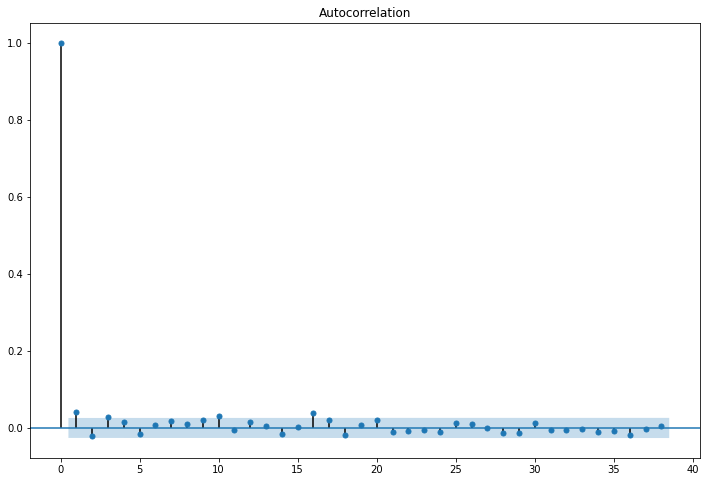

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_acf(df.eur, ax=ax)
plt.show()

### Ljung-Box

In [ ]:
lb = pd.DataFrame(sm.stats.acorr_ljungbox(df.usd, lags=[10])).T
lb.columns = ['Estatística de Teste', 'p-valor']
lb

,Estatística de Teste,p-valor
0,53.129701,7.044181e-08


### Hypothesis Testing

In [ ]:
# Estacionariedade

cols = ['USD', 'EUR', 'GBP', 'JPY']

def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística de Teste','p-valor','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico a %s'%key] = value        
    adf_df = dfoutput.to_frame()
    return adf_df

adf_usd = adf_test(df.usd)
adf_eur = adf_test(df.eur)
adf_gbp = adf_test(df.gbp)
adf_jpy = adf_test(df.jpy)

adf_1 = pd.merge(adf_usd, adf_eur, how='left', left_index=True, right_index=True)
adf_2 = pd.merge(adf_1, adf_gbp, how='left', left_index=True, right_index=True)
adf_results = pd.merge(adf_2, adf_jpy, how='left', left_index=True, right_index=True)

adf_results.columns = cols
adf_results

,USD,EUR,GBP,JPY
Estatística de Teste,-1.713295e+01,-52.409201,-52.040900,-1.631769e+01
p-valor,7.129185e-30,0.000000,0.000000,3.150215e-29
#Lags Used,1.900000e+01,1.000000,1.000000,1.900000e+01
Number of Observations Used,5.500000e+03,5518.000000,5518.000000,5.500000e+03
Valor Crítico a 1%,-3.431540e+00,-3.431536,-3.431536,-3.431540e+00
Valor Crítico a 5%,-2.862066e+00,-2.862064,-2.862064,-2.862066e+00
Valor Crítico a 10%,-2.567050e+00,-2.567049,-2.567049,-2.567050e+00


In [ ]:
# adf_results.to_excel('adf_results.xlsx')

### QQ Plot

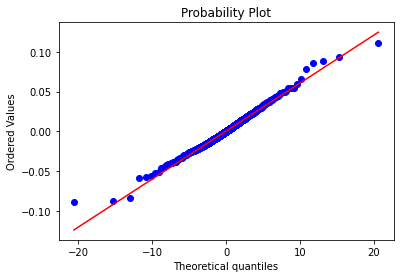

In [ ]:
stats.probplot(df.usd, dist=stats.t(3), plot=pylab)
pylab.show()

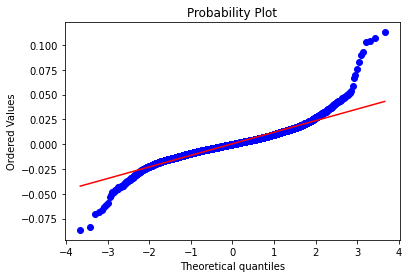

In [ ]:
stats.probplot(df.jpy, dist='norm', plot=pylab)
pylab.show()

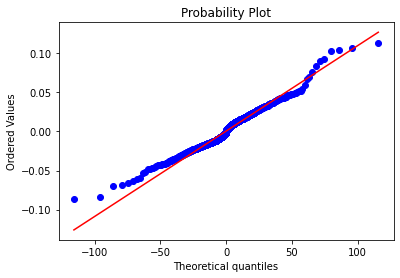

In [ ]:
stats.probplot(df.jpy, dist=stats.gennorm(0.5), plot=pylab)
pylab.show()